In [2]:
from clean_asurv import read_asurv

In [3]:
years_through_2011 = 30
temporal_res = 'weekly'
box_length_m = 500
complete_idx_square = True
keep_geometry_col = False
# END PARAMS

asurv_gdf = read_asurv(years_through_2011, temporal_res=temporal_res)

## x, y, time, count

In [4]:
asurv_gdf.columns

Index(['date', 'week', 'week_name', 'X', 'Y', 'count', 'geometry'], dtype='object')

In [6]:
asurv_gdf

,date,week,week_name,X,Y,count,geometry
9894,1979-04-13,15,1979-04-08_to_1979-04-15,711116.3135,3.120143e+06,3.0,POINT (711116.314 3120142.649)
9895,1979-04-13,15,1979-04-08_to_1979-04-15,710976.4147,3.118770e+06,2.0,POINT (710976.415 3118770.451)
9896,1979-04-13,15,1979-04-08_to_1979-04-15,708294.0421,3.118293e+06,3.0,POINT (708294.042 3118292.944)
9897,1979-04-13,15,1979-04-08_to_1979-04-15,703759.2864,3.113870e+06,2.0,POINT (703759.286 3113869.949)
9898,1979-04-13,15,1979-04-08_to_1979-04-15,703378.2856,3.113591e+06,5.0,POINT (703378.286 3113590.548)
...,...,...,...,...,...,...,...
38327,2011-03-01,1679,2011-02-27_to_2011-03-06,715558.6950,3.124125e+06,2.0,POINT (715558.695 3124124.849)
38328,2011-03-01,1679,2011-02-27_to_2011-03-06,713971.1918,3.123273e+06,2.0,POINT (713971.192 3123272.889)
38329,2011-03-01,1679,2011-02-27_to_2011-03-06,713637.8162,3.122786e+06,3.0,POINT (713637.816 3122786.054)
38330,2011-03-01,1679,2011-02-27_to_2011-03-06,712955.1898,3.121251e+06,2.0,POINT (712955.19 3121251.468)


In [7]:
asurv_gdf[['date', 'week', 'week_name', 'X', 'Y', 'count', 'geometry']]

,date,week,week_name,X,Y,count,geometry
9894,1979-04-13,15,1979-04-08_to_1979-04-15,711116.3135,3.120143e+06,3.0,POINT (711116.314 3120142.649)
9895,1979-04-13,15,1979-04-08_to_1979-04-15,710976.4147,3.118770e+06,2.0,POINT (710976.415 3118770.451)
9896,1979-04-13,15,1979-04-08_to_1979-04-15,708294.0421,3.118293e+06,3.0,POINT (708294.042 3118292.944)
9897,1979-04-13,15,1979-04-08_to_1979-04-15,703759.2864,3.113870e+06,2.0,POINT (703759.286 3113869.949)
9898,1979-04-13,15,1979-04-08_to_1979-04-15,703378.2856,3.113591e+06,5.0,POINT (703378.286 3113590.548)
...,...,...,...,...,...,...,...
38327,2011-03-01,1679,2011-02-27_to_2011-03-06,715558.6950,3.124125e+06,2.0,POINT (715558.695 3124124.849)
38328,2011-03-01,1679,2011-02-27_to_2011-03-06,713971.1918,3.123273e+06,2.0,POINT (713971.192 3123272.889)
38329,2011-03-01,1679,2011-02-27_to_2011-03-06,713637.8162,3.122786e+06,3.0,POINT (713637.816 3122786.054)
38330,2011-03-01,1679,2011-02-27_to_2011-03-06,712955.1898,3.121251e+06,2.0,POINT (712955.19 3121251.468)


### Testing GPS

In [8]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
from shapely.geometry import Polygon
import numpy as np
import geopandas as gpd
import os


# Function to generate a grid of boxes
def generate_grid(bbox, spacing, crs):
    """
    Generate box grid based on min x, min y, max x, and max y (LONG/LAT)
    Spacing: Space between each box in degrees
    Crs: Coordinate reference system
    """
    METERS_PER_DEGREE = 111111

    if crs.to_string() == 'EPSG:26914':
        spacing = spacing * METERS_PER_DEGREE

    minx, miny, maxx, maxy = bbox
    x_coords = np.arange(minx, maxx, spacing)
    y_coords = np.arange(miny, maxy, spacing)

    grid = []
    for x in x_coords:
        for y in y_coords:
            grid.append(Polygon([(x, y), (x + spacing, y), (x + spacing, y + spacing), (x, y + spacing), (x, y)]))
    return gpd.GeoDataFrame({'geometry': grid}, crs=crs)


In [9]:
# defining date range
DATE_RANGE_TRANSLATOR = {  
    'daily': 'D',
    'weekly': 'W',
    'biweekly': '2W',
    'monthly': 'M'
}
# how much temporal buffer to give based on resolution
DATE_OFFSET_TRANSLATOR = {  
    'daily': 1,
    'weekly': 7,
    'biweekly': 14,
    'monthly': 30
}
# naming the temporal column
DATE_NAME_TRANSLATOR = {  
    'daily': 'day',
    'weekly': 'week',
    'biweekly': 'biweek',
    'monthly': 'month'
}


# meters per degree lat or long
METERS_PER_DEGREE = 111111

In [10]:
# BEGIN PARAMETERS
box_length_m = 500
temporal_res = 'weekly'
years_cut_from_back = 4
keep_geometry_col = False
# END PARAMETERS

# set gps gdf and CRS
gps_gdf = pd.read_csv('raw-data/WHCR_locations_gps.csv')
gps_gdf = gpd.GeoDataFrame(gps_gdf, geometry=gpd.points_from_xy(gps_gdf.Long, gps_gdf.Lat), crs='EPSG:4326')
gps_gdf = gps_gdf.set_crs('EPSG:4326', allow_override=True)
gps_gdf = gps_gdf.to_crs('EPSG:26914')
gps_gdf['Date'] = pd.to_datetime(gps_gdf['Date'])
gps_gdf['Year'] = gps_gdf['Date'].dt.year
valid_years = gps_gdf['Year'].unique()[:len(gps_gdf['Year'].unique()) - years_cut_from_back]
gps_gdf = gps_gdf[gps_gdf['Year'].isin(valid_years)]

aransas_df = pd.read_csv('raw-data/asurv_1950_to_2011/WHCR_Aerial_Observations_1950_2011.txt', encoding='latin1', sep='\t')
aransas_gdf = gpd.GeoDataFrame(aransas_df, geometry=gpd.points_from_xy(aransas_df.X, aransas_df.Y), crs='EPSG:26914')

# Set spacing and generate the grid
bbox = aransas_gdf.total_bounds
box_length_degrees = box_length_m / METERS_PER_DEGREE
grid_gdf = generate_grid(bbox, box_length_degrees, crs=aransas_gdf.crs)

all_dates = pd.date_range(start=gps_gdf['Date'].min() - DateOffset(days=DATE_OFFSET_TRANSLATOR[temporal_res]), end=gps_gdf['Date'].max() + DateOffset(days=DATE_OFFSET_TRANSLATOR[temporal_res]), freq=DATE_RANGE_TRANSLATOR[temporal_res])
gps_gdf[DATE_NAME_TRANSLATOR[temporal_res]] = np.searchsorted(all_dates, gps_gdf['Date'])  

# add names for weeks for data clarity
bin_names = {i + 1: f'{all_dates[i].date()}_to_{all_dates[i + 1].date()}' for i in range(len(all_dates) - 1)}
gps_gdf[f'{DATE_NAME_TRANSLATOR[temporal_res]}_name'] = gps_gdf[DATE_NAME_TRANSLATOR[temporal_res]].map(bin_names)


In [25]:
gps_gdf.columns

Index(['BirdID', 'Date', 'Time', 'Season', 'Direction', 'Speed', 'Quality',
       'Alt', 'Alt_error', 'Acquisition', 'Bird_status', 'Filter1', 'Filter2',
       'Filter3', 'Filter4', 'Truncate', 'Long', 'Lat', 'geometry', 'Year',
       'week', 'week_name'],
      dtype='object')

,Date,Time,Long,Lat,geometry,week,week_name
0,2009-12-13,13:47,-97.0090,28.1523,POINT (695506.207 3115676.727),1,2009-12-06_to_2009-12-13
1,2009-12-13,19:45,-97.0110,28.1569,POINT (695301.419 3116183.256),1,2009-12-06_to_2009-12-13
2,2009-12-14,1:45,-97.0111,28.1566,POINT (695292.143 3116149.85),2,2009-12-13_to_2009-12-20
3,2009-12-14,7:45,-97.0064,28.1571,POINT (695752.834 3116212.831),2,2009-12-13_to_2009-12-20
4,2009-12-14,13:45,-97.0077,28.1583,POINT (695622.975 3116343.713),2,2009-12-13_to_2009-12-20
...,...,...,...,...,...,...,...
163523,2014-12-31,5:05,-96.9042,28.1498,POINT (705804.324 3115572.959),265,2014-12-28_to_2015-01-04
163524,2014-12-31,9:52,-96.9170,28.1448,POINT (704556.581 3114997.227),265,2014-12-28_to_2015-01-04
163525,2014-12-31,14:39,-96.9063,28.1345,POINT (705627.293 3113873.873),265,2014-12-28_to_2015-01-04
163526,2014-12-31,18:02,-96.9101,28.1381,POINT (705247.128 3114266.39),265,2014-12-28_to_2015-01-04


In [33]:
gps_gdf.loc[0, 'geometry'].x

695506.2065440463

In [34]:
# Set spacing and generate the grid
aransas_df = pd.read_csv('raw-data/asurv_1950_to_2011/WHCR_Aerial_Observations_1950_2011.txt', encoding='latin1', sep='\t')
aransas_gdf = gpd.GeoDataFrame(aransas_df, geometry=gpd.points_from_xy(aransas_df.X, aransas_df.Y), crs='EPSG:26914')
bbox = aransas_gdf.total_bounds
box_length_degrees = box_length_m / METERS_PER_DEGREE
grid_gdf = generate_grid(bbox, box_length_degrees, crs=aransas_gdf.crs)
gps_gdf[DATE_NAME_TRANSLATOR[temporal_res]] = np.searchsorted(all_dates, gps_gdf['Date'])  
boxes_in_aransas = gpd.sjoin(gps_gdf, grid_gdf, how='left', predicate='within')
boxes_only_aransas = boxes_in_aransas[~boxes_in_aransas['index_right'].isna()]


In [36]:
boxes_only_aransas.total_bounds

array([ 692727.16613303, 3095057.86421297,  753687.33167348,
       3159982.50436361])

# Determining appropriate K value: gps

In [11]:
gps_df = pd.read_csv('gps/2009_to_2014_weekly_500M/gps_2009_to_2014_weekly_500M_final.csv')

In [12]:
gps_df['longlat'] = gps_df.apply(lambda row: (row['long'], row['lat']), axis=1)

Text(0.5, 1.0, 'Choosing K: ')

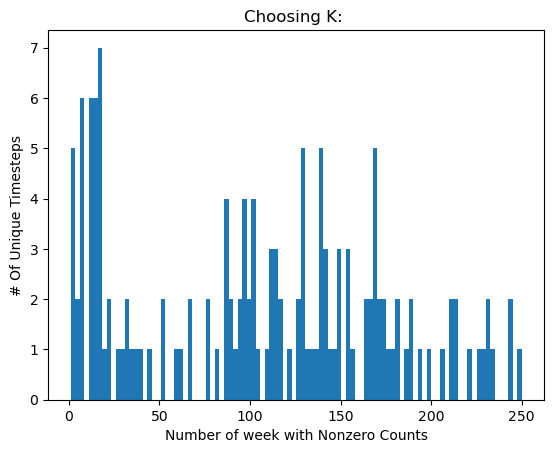

In [13]:
def calc_num_nonzero(group):

    if np.sum(group['counts'] > 0) == 0:
        return np.nan 
    
    return np.sum(group['counts'] > 0)


import matplotlib.pyplot as plt
plt.hist(gps_df.groupby('week_name').apply(calc_num_nonzero).dropna(), bins=100)
plt.xlabel('Number of week with Nonzero Counts')
plt.ylabel('# Of Unique Timesteps')
plt.title('Choosing K: ')

## Perhaps 50 is a good number

## Trying on asurv

In [2]:
import pandas as pd

In [3]:
asurv_df = pd.read_csv('asurv/1992_to_2011_weekly_500M/asurv_1992_to_2011_weekly_500M_RawPts.csv')
asurv_df

,Unnamed: 0,date,week,week_name,X,Y,count,geometry
0,17018,1990-02-11,4,1990-02-04_to_1990-02-11,708361.8045,3.110617e+06,3.0,POINT (708361.8045 3110617.3133)
1,17019,1990-02-11,4,1990-02-04_to_1990-02-11,709854.0575,3.109125e+06,2.0,POINT (709854.0575 3109125.0603)
2,17020,1990-02-11,4,1990-02-04_to_1990-02-11,706599.6760,3.110141e+06,2.0,POINT (706599.676 3110141.0624)
3,17021,1990-02-11,4,1990-02-04_to_1990-02-11,705663.0491,3.108688e+06,2.0,POINT (705663.0491 3108688.497)
4,17022,1990-02-11,4,1990-02-04_to_1990-02-11,704488.2968,3.106410e+06,2.0,POINT (704488.2968 3106410.4299)
...,...,...,...,...,...,...,...,...
19459,38327,2011-03-01,1103,2011-02-27_to_2011-03-06,715558.6950,3.124125e+06,2.0,POINT (715558.695 3124124.8487)
19460,38328,2011-03-01,1103,2011-02-27_to_2011-03-06,713971.1918,3.123273e+06,2.0,POINT (713971.1918 3123272.8887)
19461,38329,2011-03-01,1103,2011-02-27_to_2011-03-06,713637.8162,3.122786e+06,3.0,POINT (713637.8162 3122786.0544)
19462,38330,2011-03-01,1103,2011-02-27_to_2011-03-06,712955.1898,3.121251e+06,2.0,POINT (712955.1898 3121251.468)


In [4]:
asurv_df['longlat'] = asurv_df.apply(lambda row: (row['X'], row['Y']), axis=1)

Text(0.5, 1.0, 'Choosing K: ')

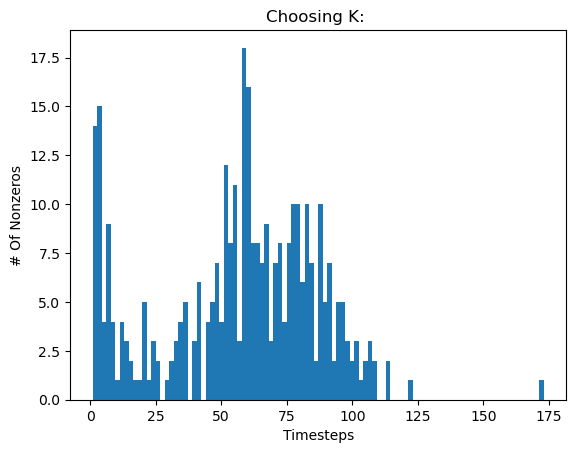

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def calc_num_nonzero(group):

    if np.sum(group['count'] > 0) == 0:
        return np.nan 
    
    return np.sum(group['count'] > 0)


import matplotlib.pyplot as plt
plt.hist(asurv_df.groupby('week_name').apply(calc_num_nonzero), bins=100)
plt.xlabel('Timesteps')
plt.ylabel('# Of Nonzeros')
plt.title('Choosing K: ')

In [19]:
(asurv_df.groupby('week_name').apply(calc_num_nonzero) > 120).sum()

2